In [1]:
!pip install nltk

In [2]:
!pip install spacy

In [3]:
import os
from glob import glob
import numpy as np
import pandas as pd
import json, nltk
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
np.random.seed(42)
nltk.download('punkt')
from nltk.tokenize import ToktokTokenizer
import string, spacy,unicodedata, random
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
train_df = pd.read_csv("/kaggle/input/dravidianlangtech/Fake_train.csv")
dev_df = pd.read_csv("/kaggle/input/dravidianlangtech/Fake_dev.csv")
test_df= pd.read_csv("/kaggle/input/dravidianlangtech/Fake_test_with_labels.csv")

print("Total number of training samples:", len(train_df))
print("Total number of dev samples:", len(dev_df))
print("Total number of test samples:", len(test_df))

Total number of training samples: 3257
Total number of dev samples: 815
Total number of test samples: 1019


In [5]:
train_df.shape

(3257, 2)

In [6]:
train_df.head(10)

,text,label
0,നല്ല അവതരണം. സത്യം പുറത്തു വരട്ടെ,Fake
1,Masha Allah,Fake
2,"അന്വേഷണം കഴിയുമ്പോൾ,. C. A. A. യ്ക്ക് എതിരായ ക...",Fake
3,Illathentha avaru purath vidayittalland verenth,Fake
4,Barana pakshathin matoru niyamam.nalla moyanth...,original
5,Marunnu adyam kandupidichittey virous kandupid...,Fake
6,Sudappikal Naadu mudikkum. Moorikallkk eandhu ...,Fake
7,നാണമുണ്ടോ ഗവണ്മെന്റെ?,original
8,Aaayur Veathana an Oru vitamin Aaalugal Sareer...,Fake
9,😂😂😂😂😂😂patt sakhavine pokki parayuano atho trol...,original


In [7]:
test_df.head(10)

,text,label
0,5000 ഉള്ള പോൾ ലോഗ്‌ഡ്‌വൻ ഇപ്പോള് 250000 എന്താ...,Fake
1,ഓഷോ രജനീഷ് പറഞ്ഞപോലെ എനിക്കപ്പോൾ തോന്നിയത് അ...,Fake
2,ചേട്ടാ വാർത്ത വയ്ക്കുന്നത് കേരളത്തിലാണ് സം...,Fake
3,Shame for entire Woman&#39;s of Kerala,original
4,135 code janaghal andhu wide business cheythal...,Fake
5,Why not all countries club together n block ch...,Fake
6,Ethil appuram നാണക്കേഡ് വന്നിട്ടില്ല cpmne🤣🤣🤣a...,original
7,കൊറോണ പോയി ഒന്ന് കൂടെ മെച്ചപ്പെട്ട് ഓമൈക്രോനായ...,original
8,മോളെ. ഇത് കോമഡി സ്റ്റാർസ് അല്ല. ചിരിച്ചും കളിച...,Fake
9,Marunaadan kandupidutham,Fake


In [8]:
dev_df.head(10)

,text,label
0,Full. Musilm. Verodamum,Fake
1,പക്ഷികളും മൃഗങ്ങളും ഈ ലോകത്ത് സുഖമായി ജീവിക്കു...,Fake
2,ഒരു താടിക്കാരൻ പാത്രം കൊട്ടാൻ പറഞ്ഞപ്പോ .........,original
3,കുംഭളേമ<br>മറന്നോ,original
4,ഇത് തിരുവാതിര അല്ല...... കോറോണയെ കൈകൊട്ടി കൊല്...,original
5,Kejriwal failed to control these people.,Fake
6,അനുഭവിച്ചോളി അവന്മാരുടെ ഒടുക്കത്തെ കളി ഇതൊക്കെ...,original
7,Climax polichuu....🤣🤣,original
8,ഈ സംഗീതത്തിന് ഈ വർഷത്തെ അവാർഡ് ഉറപ്പ്.!!😢,original
9,ആരും അടിവര ഇടാതെ തന്നെ വിവരമുള്ളവർക് അറിയാം കമ...,Fake


## See Word Length

In [9]:
# Function to count words in a text
def word_count(text):
    words = str(text).split()  # Splitting text into words
    return len(words)  # Returning the count of words

train_word_length = train_df['text'].apply(word_count)
dev_word_length = dev_df['text'].apply(word_count)
test_word_length = test_df['text'].apply(word_count)

In [10]:
#Max word length for each dataset
print(train_word_length.max())
print(dev_word_length.max())
print(test_word_length.max())

338
178
154


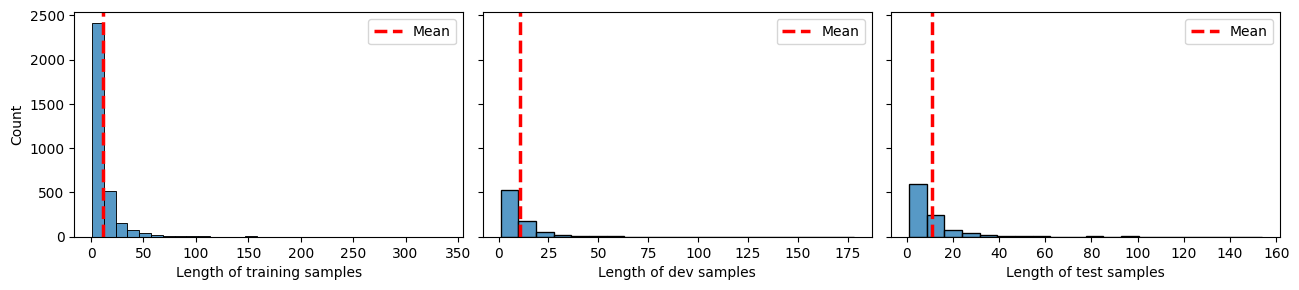

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up subplots with shared y-axis
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(13, 3), sharey=True)

# Plot for training data
sns.histplot(data=train_word_length, bins=30, ax=ax[0]).set(xlabel="Length of training samples")
ax[0].axvline(x=train_word_length.mean(), color="red", linestyle="--", linewidth=2.5, label="Mean")
ax[0].legend()

# Plot for development data
sns.histplot(data=dev_word_length, bins=20, ax=ax[1]).set(xlabel="Length of dev samples")
ax[1].axvline(x=dev_word_length.mean(), color="red", linestyle="--", linewidth=2.5, label="Mean")
ax[1].legend()

# Plot for test data
sns.histplot(data=test_word_length, bins=20, ax=ax[2]).set(xlabel="Length of test samples")
ax[2].axvline(x=test_word_length.mean(), color="red", linestyle="--", linewidth=2.5, label="Mean")
ax[2].legend()

# Show the plots
plt.tight_layout()
plt.show()


### No of unique words

In [12]:
import re

train_corpus = train_df["text"].sum()
dev_corpus = dev_df["text"].sum()
test_corpus = test_df["text"].sum()

# Remove punctuations
ch_to_ignore = '[-,\.:;\'"\!?।]'

train_corpus = re.sub(ch_to_ignore, ' ', train_corpus)
train_word = set(train_corpus.split())

dev_corpus = re.sub(ch_to_ignore, ' ', dev_corpus)
dev_word = set(dev_corpus.split())

test_corpus = re.sub(ch_to_ignore, ' ', test_corpus)
test_word = set(test_corpus.split())

new_words = test_word - train_word - dev_word

In [13]:
print("Number of unique words in training data:", len(train_word))
print("Number of unique words in dev data:", len(dev_word))
print("Number of unique words in test data:", len(test_word))
print("Number of new words in test data:", len(new_words))

Number of unique words in training data: 18526
Number of unique words in dev data: 5581
Number of unique words in test data: 6738
Number of new words in test data: 3914


## Top 50 common words

In [14]:
from collections import Counter

# Tokenize the training corpus after removing punctuations
train_corpus = re.sub(ch_to_ignore, ' ', train_corpus)
train_tokens = train_corpus.split()

# Count the frequency of each word
train_word_counts = Counter(train_tokens)

# Get the 50 most common words in descending order
most_common_words = train_word_counts.most_common(50)

# Print the results
print("Top 50 most common words in training data:")
for word, count in most_common_words:
    print(f"Word: '{word}', Frequency: {count}")


Top 50 most common words in training data:
Word: 'ഒരു', Frequency: 347
Word: 'the', Frequency: 200
Word: 'ഈ', Frequency: 185
Word: 'എന്ന്', Frequency: 138
Word: 'തന്നെ', Frequency: 130
Word: 'ആണ്', Frequency: 126
Word: 'of', Frequency: 125
Word: 'to', Frequency: 123
Word: 'is', Frequency: 117
Word: 'and', Frequency: 115
Word: 'കൊറോണ', Frequency: 115
Word: 'അത്', Frequency: 96
Word: 'തിരുവാതിര', Frequency: 92
Word: 'in', Frequency: 89
Word: 'a', Frequency: 87
Word: 'ചൈന', Frequency: 85
Word: 'ഇത്', Frequency: 80
Word: 'oru', Frequency: 80
Word: 'പാർട്ടി', Frequency: 67
Word: 'കോവിഡ്', Frequency: 61
Word: 'for', Frequency: 58
Word: 'ഇനി', Frequency: 58
Word: 'അവർ', Frequency: 56
Word: 'ആ', Frequency: 56
Word: 'are', Frequency: 55
Word: 'വൈറസ്', Frequency: 55
Word: 'corona', Frequency: 55
Word: 'എന്ത്', Frequency: 54
Word: 'എല്ലാം', Frequency: 54
Word: 'നല്ല', Frequency: 53
Word: 'കൂടി', Frequency: 51
Word: 'ഇല്ല', Frequency: 51
Word: 'മാത്രം', Frequency: 50
Word: 'പിണറായി', Frequency: 48

In [15]:
# Tokenize the dev corpus after removing punctuations
dev_corpus = re.sub(ch_to_ignore, ' ', dev_corpus)
dev_tokens = dev_corpus.split()

# Count the frequency of each word
dev_word_counts = Counter(dev_tokens)

# Get the 50 most common words in descending order
most_common_dev_words = dev_word_counts.most_common(50)

# Print the results
print("Top 50 most common words in dev data:")
for word, count in most_common_dev_words:
    print(f"Word: '{word}', Frequency: {count}")


Top 50 most common words in dev data:
Word: 'ഒരു', Frequency: 72
Word: 'the', Frequency: 48
Word: 'ഈ', Frequency: 38
Word: 'and', Frequency: 38
Word: 'to', Frequency: 37
Word: 'തന്നെ', Frequency: 34
Word: 'എന്ന്', Frequency: 33
Word: 'തിരുവാതിര', Frequency: 30
Word: 'of', Frequency: 29
Word: 'ആണ്', Frequency: 25
Word: 'കൊറോണ', Frequency: 25
Word: 'oru', Frequency: 24
Word: 'അവർ', Frequency: 21
Word: 'is', Frequency: 19
Word: '&quot', Frequency: 18
Word: 'മരുന്ന്', Frequency: 18
Word: 'അത്', Frequency: 17
Word: 'China', Frequency: 17
Word: 'in', Frequency: 17
Word: 'are', Frequency: 16
Word: 'this', Frequency: 15
Word: 'a', Frequency: 14
Word: 'ഉള്ള', Frequency: 14
Word: 'ചൈന', Frequency: 14
Word: 'ee', Frequency: 14
Word: 'you', Frequency: 14
Word: '&#39', Frequency: 14
Word: 'വലിയ', Frequency: 13
Word: 'പാർട്ടി', Frequency: 13
Word: 'be', Frequency: 13
Word: 'it', Frequency: 13
Word: 'corona', Frequency: 12
Word: 'ഇല്ല', Frequency: 12
Word: 'നിയമം', Frequency: 12
Word: 'people', Frequ

## See code mixed rows

In [16]:
# Filter rows where 'text' contains alphanumeric characters
filtered_train = train_df[train_df["text"].str.contains("[A-Za-z0-9]")]
print("Filtered training data shape:", filtered_train.shape)

filtered_dev = dev_df[dev_df["text"].str.contains("[A-Za-z0-9]")]
print("Filtered dev data shape:", filtered_dev.shape)

filtered_test = test_df[test_df["text"].str.contains("[A-Za-z0-9]")]
print("Filtered test data shape:", filtered_test.shape)

Filtered training data shape: (1874, 2)
Filtered dev data shape: (475, 2)
Filtered test data shape: (597, 2)


In [17]:
!pip install indic-transliteration
!pip install malaya
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from tqdm import tqdm
import malaya
from malaya.text.function import STOPWORDS
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

# Install necessary libraries
!pip install malaya
!pip install indic-transliteration

# Initialize stopwords
stop_words = STOPWORDS

# Ensure necessary resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Define punctuations to remove
punctuations = '''’'!()-[]{};:'"\,<>./?@#$%^&*_~�'''

# Function to remove URLs and punctuations
def remove_punctuation_url(text):
    text = text.lower()
    # Remove URLs
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    # Remove unwanted characters
    text = text.replace('\n', ' ')
    # Remove punctuations
    text = ''.join(char for char in text if char not in punctuations)
    return text

# Function to remove stopwords
def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    tokens_without_sw = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens_without_sw)

# Function to remove HTML tags
def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

# Function to transliterate text into Malayalam using indic-transliteration
def transliterate_to_malayalam(text):
    return transliterate(text, sanscript.ITRANS, sanscript.MALAYALAM)

# Master function for preprocessing
def full_preprocessing(text):
    text = remove_html_tags(text)  # Remove HTML tags
    text = remove_punctuation_url(text)  # Remove URLs and punctuations
    text = remove_stopwords(text)  # Remove stopwords
    text = transliterate_to_malayalam(text)  # Transliterate to Malayalam
    return text

# Apply preprocessing on training, validation, and test datasets
tqdm.pandas(desc="Processing Text")

# Assuming train, dev datasets exist
train_df['cleaned'] = train_df['text'].progress_apply(full_preprocessing)
dev_df['cleaned'] = dev_df['text'].progress_apply(full_preprocessing)
test_df['cleaned'] = test_df['text'].progress_apply(full_preprocessing)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 14.7 MB/s eta 0:00:00
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Processing Text: 100%|██████████| 1019/1019 [00:00<00:00, 2327.17it/s]


In [18]:
train_df.head(10)

,text,label,cleaned
0,നല്ല അവതരണം. സത്യം പുറത്തു വരട്ടെ,Fake,നല്ല അവതരണം സത്യം പുറത്തു വരട്ടെ
1,Masha Allah,Fake,മശ
2,"അന്വേഷണം കഴിയുമ്പോൾ,. C. A. A. യ്ക്ക് എതിരായ ക...",Fake,അന്വേഷണം കഴിയുമ്പോൾ ച് അ അ യ്ക്ക് എതിരായ കലാപം...
3,Illathentha avaru purath vidayittalland verenth,Fake,ഇല്ലഥേന്ഥ അവരു പുരഥ് വിദയിത്തല്ലന്ദ് വേരേന്ഥ്
4,Barana pakshathin matoru niyamam.nalla moyanth...,original,ബരന പക്ശഥിന് മതോരു നിയമമ്നല്ല മോയന്ഥ് മന്ഥ്രീ
5,Marunnu adyam kandupidichittey virous kandupid...,Fake,മരുന്നു അദ്യമ് കന്ദുപിദിചിത്തേയ് വിരോഉസ് കന്ദു...
6,Sudappikal Naadu mudikkum. Moorikallkk eandhu ...,Fake,സുദപ്പികല് നാദു മുദിക്കുമ് മൂരികല്ല്ക്ക് ഏഅന്ധ...
7,നാണമുണ്ടോ ഗവണ്മെന്റെ?,original,നാണമുണ്ടോ ഗവണ്മെന്റെ
8,Aaayur Veathana an Oru vitamin Aaalugal Sareer...,Fake,ആഅയുര് വേഅഥന അന് ഓരു വിതമിന് ആഅലുഗല് സരീരഥിന് ...
9,😂😂😂😂😂😂patt sakhavine pokki parayuano atho trol...,original,😂😂😂😂😂😂പത്ത് സഖവിനേ പോക്കി പരയുഅനോ അഥോ ത്രോല്ലുവനോ


In [19]:
test_df.head()

,text,label,cleaned
0,5000 ഉള്ള പോൾ ലോഗ്‌ഡ്‌വൻ ഇപ്പോള് 250000 എന്താ...,Fake,൫൦൦൦ ഉള്ള പോൾ ലോഗ്‌ഡ്‌വൻ ഇപ്പോള് ൨൫൦൦൦൦ എന്താ ...
1,ഓഷോ രജനീഷ് പറഞ്ഞപോലെ എനിക്കപ്പോൾ തോന്നിയത് അ...,Fake,ഓഷോ രജനീഷ് പറഞ്ഞപോലെ എനിക്കപ്പോൾ തോന്നിയത് അങ്...
2,ചേട്ടാ വാർത്ത വയ്ക്കുന്നത് കേരളത്തിലാണ് സം...,Fake,ചേട്ടാ വാർത്ത വയ്ക്കുന്നത് കേരളത്തിലാണ് സംഘി ഭ...
3,Shame for entire Woman&#39;s of Kerala,original,ശമേ fോര് ഏന്തിരേ വോമന്സ് ഓf് കേരല
4,135 code janaghal andhu wide business cheythal...,Fake,൧൩൫ ചോദേ ജനഘല് അന്ധു വിദേ ബുസിനേസ്സ് ചേയ്ഥലുമ്...


In [20]:
dev_df.head()

,text,label,cleaned
0,Full. Musilm. Verodamum,Fake,fുല്ല് മുസില്മ് വേരോദമുമ്
1,പക്ഷികളും മൃഗങ്ങളും ഈ ലോകത്ത് സുഖമായി ജീവിക്കു...,Fake,പക്ഷികളും മൃഗങ്ങളും ഈ ലോകത്ത് സുഖമായി ജീവിക്കു...
2,ഒരു താടിക്കാരൻ പാത്രം കൊട്ടാൻ പറഞ്ഞപ്പോ .........,original,ഒരു താടിക്കാരൻ പാത്രം കൊട്ടാൻ പറഞ്ഞപ്പോ മറ്റൊര...
3,കുംഭളേമ<br>മറന്നോ,original,കുംഭളേമമറന്നോ
4,ഇത് തിരുവാതിര അല്ല...... കോറോണയെ കൈകൊട്ടി കൊല്...,original,ഇത് തിരുവാതിര അല്ല കോറോണയെ കൈകൊട്ടി കൊല്ലുകയാണ...


## Preprocessing

In [21]:
def text_to_word_list(cleaned):
    text = text.split()
    return text

def replace_strings(cleaned):
    emoji_pattern = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        u"\u2600-\u2B55"          # other symbols
        u"\u200d"                 # zero-width joiner
        u"\ufe0f"                 # dingbats
        "]+", flags=re.UNICODE
    )
    
    # Remove emojis
    cleaned = emoji_pattern.sub(r'', cleaned)
    
    # Replace newlines, underscores, and extra spaces
    cleaned = cleaned.replace('\n', ' ').replace('_', ' ').replace('\r', ' ')
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    
    return cleaned                                                   

def remove_punctuations(cleaned):
    punctuations = '''````£|¢|Ñ+-*/=৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰'�'🤣⚽️✌😀😃😄😁😆😅😂🤣😊😇🙂🙃😉😌😍😘😗😙😚😋😛😝😜🤪🤨🧐🤓😎🤩🥳😏😒😞😔😟😕🙁☹️😣😖😫😩😤😠😡🤬😈👿💀☠️💩🤡👹👺👻👽👾🤖💋💌💘💝💖💗💓💞💕💟❣️💔❤️‍🔥🖤🤍💯💢💥💫💦💨🕳️💣💬👁️‍🗨️🗨️🗯️💭💤👋🤚🖐️✋🖖👌✌️🤞🤟🤘🤙👈👉👆👇☝️✍️👏👏🏻👏🏼👏🏽👏🏾👏🏿👍👍🏻👍🏼👍🏽👍🏾👍🏿👎👎🏻👎🏼👎🏽👎🏾👎🏿✊✊🏻✊🏼✊🏽✊🏾✊🏿🤛🤛🏻🤛🏼🤛🏽🤛🏾🤛🏿🤜🤜🏻🤜🏼🤜🏽🤜🏾🤜🏿🤝🙏🙏🏻🙏🏼🙏🏽🙏🏾🙏🏿✍️💅💅🏻💅🏼💅🏽💅🏾💅🏿🤳💪💪🏻💪🏼💪🏽💪🏾💪🏿🦾🦵🦿🦶👂👂🏻👂🏼👂🏽👂🏾👂🏿👃👃🏻👃🏼👃🏽👃🏾👃🏿👀🧠🫀🫁🦷🦴👅👄🦻🦻🏻🦻🏼🦻🏽🦻🏾🦻🏿👶👶🏻👶🏼👶🏽👶🏾👶🏿🧒🧒🏻🧒🏼🧒🏽🧒🏾🧒🏿👦👦🏻👦🏼👦🏽👦🏾👦🏿👧👧🏻👧🏼👧🏽👧🏾👧🏿🧑🧑🏻🧑🏼🧑🏽🧑🏾🧑🏿👨👨🏻👨🏼👨🏽👨🏾👨🏿👩👩🏻👩🏼👩🏽👩🏾👩🏿🧓🧓🏻🧓🏼🧓🏽🧓🏾🧓🏿👴👴🏻👴🏼👴🏽👴🏾👴🏿👵👵🏻👵🏼👵🏽👵🏾👵🏿👩‍🦰👩🏻‍🦰👩🏼‍🦰👩🏽‍🦰👩🏾‍🦰👩🏿‍🦰👩‍🦱👩🏻‍🦱👩🏼‍🦱👩🏽‍🦱👩🏾‍🦱👩🏿‍🦱👩‍🦳👩🏻‍🦳👩🏼‍🦳👩🏽‍🦳👩🏾‍🦳👩🏿‍🦳👩‍🦲👩🏻‍🦲👩🏼‍🦲👩🏽‍🦲👩🏾‍🦲👩🏿‍🦲👨‍🦰👨🏻‍🦰👨🏼‍🦰👨🏽‍🦰👨🏾‍🦰👨🏿‍🦰👨‍🦱👨🏻‍🦱👨🏼‍🦱👨🏽‍🦱👨🏾‍🦱👨🏿‍🦱👨‍🦳👨🏻‍🦳👨🏼👨🏽‍🦳👨🏾‍🦳👨🏿‍🦳👨‍🦲👨🏻‍🦲👨🏼‍🦲👨🏽‍🦲👨🏾‍🦲👨🏿‍🦲🦰🦱🦳🦲👱‍♀️👱🏻‍♀️❤️‍🩹❤️‍🔥❤️‍🩹🧡💛💚💙💜🤎�￰৷￰'''
    return ''.join(char for char in cleaned if char not in punctuations)



def joining(cleaned):
    out=' '.join(cleaned)
    return out

def preprocessing(cleaned):
    out=remove_punctuations(replace_strings(cleaned))
    return out

In [22]:
train_df['cleaned'] = train_df.cleaned.apply(lambda x: preprocessing(str(x)))
test_df['cleaned'] = test_df.cleaned.apply(lambda x: preprocessing(str(x)))
dev_df['cleaned']=dev_df.cleaned.apply(lambda x: preprocessing(str(x)))
#test_df['cleaned']=test_df.cleanText.apply(lambda x: preprocessing(str(x)))

In [23]:
# Convert content to string and handle 'NaN' values
train_df['cleaned'] = train_df['cleaned'].apply(lambda x: '' if pd.isna(x) else str(x))
test_df['cleaned'] = test_df['cleaned'].apply(lambda x: '' if pd.isna(x) else str(x))
dev_df['cleaned'] = dev_df['cleaned'].apply(lambda x: '' if pd.isna(x) else str(x))

In [24]:
train_df.head(10)

,text,label,cleaned
0,നല്ല അവതരണം. സത്യം പുറത്തു വരട്ടെ,Fake,നല്ല അവതരണം സത്യം പുറത്തു വരട്ടെ
1,Masha Allah,Fake,മശ
2,"അന്വേഷണം കഴിയുമ്പോൾ,. C. A. A. യ്ക്ക് എതിരായ ക...",Fake,അന്വേഷണം കഴിയുമ്പോൾ ച് അ അ യ്ക്ക് എതിരായ കലാപം...
3,Illathentha avaru purath vidayittalland verenth,Fake,ഇല്ലഥേന്ഥ അവരു പുരഥ് വിദയിത്തല്ലന്ദ് വേരേന്ഥ്
4,Barana pakshathin matoru niyamam.nalla moyanth...,original,ബരന പക്ശഥിന് മതോരു നിയമമ്നല്ല മോയന്ഥ് മന്ഥ്രീ
5,Marunnu adyam kandupidichittey virous kandupid...,Fake,മരുന്നു അദ്യമ് കന്ദുപിദിചിത്തേയ് വിരോഉസ് കന്ദു...
6,Sudappikal Naadu mudikkum. Moorikallkk eandhu ...,Fake,സുദപ്പികല് നാദു മുദിക്കുമ് മൂരികല്ല്ക്ക് ഏഅന്ധ...
7,നാണമുണ്ടോ ഗവണ്മെന്റെ?,original,നാണമുണ്ടോ ഗവണ്മെന്റെ
8,Aaayur Veathana an Oru vitamin Aaalugal Sareer...,Fake,ആഅയുര് വേഅഥന അന് ഓരു വിതമിന് ആഅലുഗല് സരീരഥിന് ...
9,😂😂😂😂😂😂patt sakhavine pokki parayuano atho trol...,original,പത്ത് സഖവിനേ പോക്കി പരയുഅനോ അഥോ ത്രോല്ലുവനോ


In [25]:
train_df['label'].value_counts()

label
original    1658
Fake        1599
Name: count, dtype: int64

In [26]:
dev_df['label'].value_counts()

label
original    409
Fake        406
Name: count, dtype: int64

In [27]:
test_df['label'].value_counts()

label
original    512
Fake        507
Name: count, dtype: int64

In [28]:
train_df['enc_label'] = train_df['label'].replace({'Fake':0, 'original':1})
dev_df['enc_label'] = dev_df['label'].replace({'Fake':0, 'original':1})
test_df['enc_label'] = test_df['label'].replace({'Fake':0, 'original':1})
test_df.tail(5)

,text,label,cleaned,enc_label
1014,Correct ...China cheitha ...weapon spread ing ...,Fake,ചോര്രേച്ത് ചിന ചേഇഥ വേഅപോന് സ്പ്രേഅദ് ഇന്ഗ് ആനു,0
1015,ഈ WHO പറയുന്നതനുസരിച്ചു ചികിത്സയും ലോക്ക് ഡൌൺ ...,Fake,ഈ വ്ഹോ പറയുന്നതനുസരിച്ചു ചികിത്സയും ലോക്ക് ഡൌൺ...,0
1016,Mask illa aarkum😏😏,original,മസ്ക് ഇല്ല ആര്കുമ്,1
1017,ഇയാളെ കൊറോണ. രോഗി കൾ കിടയിൽ. ഇടാമായിരുന്നു---!!,Fake,ഇയാളെ കൊറോണ രോഗി കൾ കിടയിൽ ഇടാമായിരുന്നു,0
1018,Kulathrikalkku badilayiAlavilathikal ...,original,കുലഥ്രികല്ക്കു ബദിലയിഅലവിലഥികല് കേരലുമ് നസിപ്പ...,1


In [29]:
train_df.drop(columns=['text', 'label'], inplace=True)
dev_df.drop(columns=['text', 'label'], inplace=True)
test_df.drop(columns=['text'], inplace=True)
train_df.head()

,cleaned,enc_label
0,നല്ല അവതരണം സത്യം പുറത്തു വരട്ടെ,0
1,മശ,0
2,അന്വേഷണം കഴിയുമ്പോൾ ച് അ അ യ്ക്ക് എതിരായ കലാപം...,0
3,ഇല്ലഥേന്ഥ അവരു പുരഥ് വിദയിത്തല്ലന്ദ് വേരേന്ഥ്,0
4,ബരന പക്ശഥിന് മതോരു നിയമമ്നല്ല മോയന്ഥ് മന്ഥ്രീ,1


In [30]:
X_train = train_df['cleaned'].tolist()
y_train = train_df['enc_label'].tolist()

X_valid = dev_df['cleaned'].tolist()
y_valid = dev_df['enc_label'].tolist()

X_test = test_df['cleaned']. tolist()
y_test = test_df['enc_label'].tolist()

## ML model

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming X_train, X_valid, and X_test are lists of strings or documents
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_valid)
X_test_tfidf = tfidf.transform(X_test)

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Example: Training models

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_tfidf, y_train)

model_svm = SVC(kernel='rbf')    #kernel='poly'  kernel='linear'   kernel='sigmoid'
model_svm.fit(X_train_tfidf, y_train)

model_rf = RandomForestClassifier(n_estimators=1000)
model_rf.fit(X_train_tfidf, y_train)

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_tfidf,y_train)

DecisionTreeClassifier()

### SVM

In [33]:
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_pred = model_svm.predict(X_test_tfidf)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)

print(f"Accuracy: {accuracy:.4}")
print("Classification Report:")
print(report)

Accuracy: 0.7478
Classification Report:
              precision    recall  f1-score   support

           0     0.7694    0.7041    0.7353       507
           1     0.7297    0.7910    0.7591       512

    accuracy                         0.7478      1019
   macro avg     0.7496    0.7476    0.7472      1019
weighted avg     0.7495    0.7478    0.7473      1019



### Random forest

In [34]:
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_pred = model_rf.predict(X_test_tfidf)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred,digits=4)

print(f"Accuracy: {accuracy:.4}")
print("Classification Report:")
print(report)

Accuracy: 0.7213
Classification Report:
              precision    recall  f1-score   support

           0     0.7357    0.6864    0.7102       507
           1     0.7088    0.7559    0.7316       512

    accuracy                         0.7213      1019
   macro avg     0.7223    0.7211    0.7209      1019
weighted avg     0.7222    0.7213    0.7209      1019



### Naive Bayes

In [35]:
from sklearn.naive_bayes import MultinomialNB

# Create and train the Naive Bayes model with smoothing
model_nb = MultinomialNB(alpha=0.15)  # You can adjust alpha here
model_nb.fit(X_train_tfidf, y_train)

# Predictions
y_pred_nb = model_nb.predict(X_test_tfidf)

# Evaluation
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb, digits=4)

print(f"Naive Bayes Accuracy: {accuracy_nb:.4}")
print("Naive Bayes Classification Report:")
print(report_nb)

Naive Bayes Accuracy: 0.7527
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0     0.7597    0.7357    0.7475       507
           1     0.7462    0.7695    0.7577       512

    accuracy                         0.7527      1019
   macro avg     0.7529    0.7526    0.7526      1019
weighted avg     0.7529    0.7527    0.7526      1019



### Majority Voting

In [36]:
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification

# Generate sample data (replace this with your own data)
#X, y = make_classification(n_samples=1000, n_features=20, n_classes=3, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize different classifiers
clf1 = DecisionTreeClassifier(random_state=42)
clf2 = SVC(probability=True, random_state=42)
clf3 = LogisticRegression(random_state=42)

# Create a VotingClassifier with majority voting
voting_clf = VotingClassifier(
    estimators=[('dt', clf1), ('svm', clf2), ('lr', clf3)],
    voting='hard'  # 'hard' for majority voting based on predicted class labels
)

# Fit the ensemble model
voting_clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test_tfidf)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)

print(f"Accuracy: {accuracy:.4}")
print("Classification Report:")
print(report)
#print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7507
Classification Report:
              precision    recall  f1-score   support

           0     0.7744    0.7041    0.7376       507
           1     0.7312    0.7969    0.7626       512

    accuracy                         0.7507      1019
   macro avg     0.7528    0.7505    0.7501      1019
weighted avg     0.7527    0.7507    0.7502      1019



## DL model

### LSTM

In [37]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Tokenize and pad sequences
max_words = 10000  # Maximum number of words in the vocabulary
max_len = 100      # Maximum sequence length

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)  # Fit tokenizer on training data

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# Build LSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Use 'sigmoid' for binary classification or 'softmax' for multi-class
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use 'categorical_crossentropy' for multi-class
# Build the model to see the summary
model.build(input_shape=(None, max_len))  # Define batch size and sequence length
model.summary()

# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_valid_pad, y_valid),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

# Make predictions
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")  # Adjust threshold for multi-class

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report
print(f"LSTM Accuracy: {accuracy_score(y_test, y_pred):.4}")
print("LSTM Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,465,217 (5.59 MB)

 Trainable params: 1,465,217 (5.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.5087 - loss: 0.6939 - val_accuracy: 0.4982 - val_loss: 0.6957
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4862 - loss: 0.6941 - val_accuracy: 0.4982 - val_loss: 0.6943
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4921 - loss: 0.6944 - val_accuracy: 0.5018 - val_loss: 0.6937
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5142 - loss: 0.6929 - val_accuracy: 0.5018 - val_loss: 0.6936
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5086 - loss: 0.6941 - val_accuracy: 0.5018 - val_loss: 0.6932
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4982 - loss: 0.6934 - val_accuracy: 0.4957 - val_loss: 0.6932
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5099 - loss: 0.6935 - val_accuracy: 0.5018 - val_loss: 0.6962
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5170 - loss: 0.6921 - val_accu

### BiLSTM

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Tokenize and pad sequences
max_words = 10000  # Maximum number of words in the vocabulary
max_len = 100      # Maximum sequence length

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)  # Fit tokenizer on training data

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# Build BiLSTM Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),  # First BiLSTM layer
    Dropout(0.3),
    Bidirectional(LSTM(64)),  # Second BiLSTM layer
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model to see the summary
model.build(input_shape=(None, max_len))  # Define batch size and sequence length
model.summary()

# Train the BiLSTM model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_valid_pad, y_valid),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

# Make predictions
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# Evaluation metrics
print(f"BiLSTM Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("BiLSTM Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,715,841 (6.55 MB)

 Trainable params: 1,715,841 (6.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.5683 - loss: 0.6705 - val_accuracy: 0.7828 - val_loss: 0.4592
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9105 - loss: 0.2482 - val_accuracy: 0.8160 - val_loss: 0.4243
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9645 - loss: 0.0964 - val_accuracy: 0.7926 - val_loss: 0.4439
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9658 - loss: 0.0886 - val_accuracy: 0.8061 - val_loss: 0.6405
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9746 - loss: 0.0600 - val_accuracy: 0.8123 - val_loss: 0.7118
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9770 - loss: 0.0449 - val_accuracy: 0.8086 - val_loss: 0.6541
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9789 - loss: 0.0468 - val_accuracy: 0.8061 - val_loss: 0.7660
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9832 - loss: 0.0311 - val_accu

### CNN

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Tokenize and pad sequences
max_words = 10000  # Maximum number of words in the vocabulary
max_len = 100      # Maximum sequence length

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)  # Fit tokenizer on training data

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_valid_seq = tokenizer.texts_to_sequences(X_valid)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_valid_pad = pad_sequences(X_valid_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

# Build CNN Model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),  # Convolutional layer
    MaxPooling1D(pool_size=4),          # Max pooling layer
    Dropout(0.3),                       # Dropout for regularization
    Conv1D(64, 5, activation='relu'),   # Second convolutional layer
    MaxPooling1D(pool_size=4),          # Max pooling layer
    Dropout(0.3),                       # Dropout for regularization
    GlobalMaxPooling1D(),               # Global max pooling to reduce dimensions
    Dense(64, activation='relu'),       # Dense layer
    Dense(1, activation='sigmoid')      # For binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Build the model to see the summary
model.build(input_shape=(None, max_len))  # Define batch size and sequence length
model.summary()

# Train the CNN model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_valid_pad, y_valid),
    epochs=4,
    batch_size=32,
    verbose=1
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")

# Make predictions
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# Evaluation metrics
print(f"CNN Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("CNN Classification Report:")
print(classification_report(y_test, y_pred, digits=4))


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 96, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 20, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,407,297 (5.37 MB)

 Trainable params: 1,407,297 (5.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.5682 - loss: 0.6796 - val_accuracy: 0.7411 - val_loss: 0.5640
Epoch 2/4
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8194 - loss: 0.4254 - val_accuracy: 0.7975 - val_loss: 0.4684
Epoch 3/4
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9471 - loss: 0.1654 - val_accuracy: 0.8110 - val_loss: 0.4717
Epoch 4/4
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9665 - loss: 0.0915 - val_accuracy: 0.8000 - val_loss: 0.5849
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8170 - loss: 0.5720
Test Accuracy: 0.8077
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
CNN Accuracy: 0.8077
CNN Classification Report:
              precision    recall  f1-score   support

           0     0.8463    0.7495    0.7950       507
           1     0.7772    0.8652    0.8189       512

    accuracy                         0.8077      1019
   macro avg     0.8118    0.8074    0.8069      1019
weighted avg     0.8116    0.8077  

# Tranformer models

In [40]:
!pip install transformers torch tqdm

In [41]:
from torch.utils.data import Dataset

In [42]:
import subprocess
import sys

def install_packages():
    # Uninstall packages
    subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "google-protobuf", "protobuf", "sentencepiece", "transformers"])
    
    # Install specific versions
    subprocess.check_call([sys.executable, "-m", "pip", "install", "protobuf==3.20.0"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sentencepiece==0.1.99"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers"])
    
    # Verify installation
    try:
        from transformers import AutoTokenizer
        tokenizer = AutoTokenizer.from_pretrained('ai4bharat/indic-bert')
        print("Installation successful!")
    except Exception as e:
        print(f"Verification failed: {str(e)}")

# Run the installation
install_packages()

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Installation successful!


# Indic-bert

In [43]:
import torch
from sklearn.metrics import accuracy_score, classification_report
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AutoConfig

# Set random seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
MODEL_NAME = 'ai4bharat/indic-bert'
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Define dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        if self.is_labeled and self.labels is not None:
            label = self.labels[item]
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }

# Prepare datasets and dataloaders
train_set = NewsDataset(
    texts=train_df['cleaned'].tolist(),
    labels=train_df['enc_label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    is_labeled=True
)

dev_set = NewsDataset(
    texts=dev_df['cleaned'].tolist(),
    labels=dev_df['enc_label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    is_labeled=True
)

test_set = NewsDataset(
    texts=test_df['cleaned'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    is_labeled=False  # test set doesn't have labels
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Define the model
class ClaimClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(ClaimClassifier, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.fc(pooled_output)

# Initialize model
model = ClaimClassifier(MODEL_NAME, num_labels=2)
model.to(device)

# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Training and evaluation function
def train_and_evaluate_model():
    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        total_loss = 0
        train_predictions, train_true_labels = [], []
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Store predictions and labels for accuracy calculation
            preds = torch.argmax(outputs, dim=1)
            train_predictions.extend(preds.cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())
        
        # Calculate training accuracy
        train_acc = accuracy_score(train_true_labels, train_predictions)
        train_loss = total_loss / len(train_loader)

        # Evaluation phase
        model.eval()
        dev_predictions, dev_true_labels = [], []
        
        with torch.no_grad():
            for batch in dev_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                # Forward pass
                outputs = model(input_ids, attention_mask)
                preds = torch.argmax(outputs, dim=1)
                
                # Store predictions and labels for accuracy calculation
                dev_predictions.extend(preds.cpu().numpy())
                dev_true_labels.extend(labels.cpu().numpy())
        
        # Calculate development accuracy
        dev_acc = accuracy_score(dev_true_labels, dev_predictions)

        # Print metrics for the epoch
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Dev Accuracy: {dev_acc:.4f}")

# Run training and evaluation
train_and_evaluate_model()

# Predict function for the test set
def predict_test():
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
    
    return predictions

# Generate predictions for the test set
test_predictions = predict_test()

# Evaluation metrics
print(f"Test Accuracy: {accuracy_score(test_df['enc_label'], test_predictions):.4f}")
print("Classification Report:")
print(classification_report(test_df['enc_label'], test_predictions, digits=4))


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Epoch 1/10, Loss: 0.6666, Train Accuracy: 0.6049, Dev Accuracy: 0.6528
Epoch 2/10, Loss: 0.6489, Train Accuracy: 0.6224, Dev Accuracy: 0.5877
Epoch 3/10, Loss: 0.6091, Train Accuracy: 0.6632, Dev Accuracy: 0.7067
Epoch 4/10, Loss: 0.6125, Train Accuracy: 0.6512, Dev Accuracy: 0.6736
Epoch 5/10, Loss: 0.5819, Train Accuracy: 0.7031, Dev Accuracy: 0.6577
Epoch 6/10, Loss: 0.5687, Train Accuracy: 0.7169, Dev Accuracy: 0.7239
Epoch 7/10, Loss: 0.5546, Train Accuracy: 0.7421, Dev Accuracy: 0.7227
Epoch 8/10, Loss: 0.5365, Train Accuracy: 0.7421, Dev Accuracy: 0.7571
Epoch 9/10, Loss: 0.4942, Train Accuracy: 0.7734, Dev Accuracy: 0.7607
Epoch 10/10, Loss: 0.4449, Train Accuracy: 0.8075, Dev Accuracy: 0.7693
Test Accuracy: 0.7468
Classification Report:
              precision    recall  f1-score   support

           0     0.8184    0.6312    0.7127       507
           1     0.7022    0.8613    0.7737       512

    accuracy                         0.7468      1019
   macro avg     0.7603   

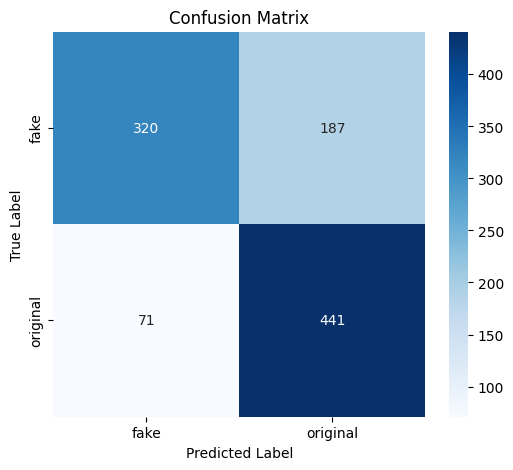

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(test_df['enc_label'], test_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['fake', 'original'], yticklabels=['fake', 'original'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# mBERT

In [45]:
import torch
from sklearn.metrics import accuracy_score, classification_report
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AutoConfig

# Set random seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
MODEL_NAME = 'bert-base-multilingual-cased'
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Define dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        if self.is_labeled and self.labels is not None:
            label = self.labels[item]
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }

# Prepare datasets and dataloaders
train_set = NewsDataset(
    texts=train_df['cleaned'].tolist(),
    labels=train_df['enc_label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    is_labeled=True
)

dev_set = NewsDataset(
    texts=dev_df['cleaned'].tolist(),
    labels=dev_df['enc_label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    is_labeled=True
)

test_set = NewsDataset(
    texts=test_df['cleaned'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    is_labeled=False  # test set doesn't have labels
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Define the model
class ClaimClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(ClaimClassifier, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        return self.fc(pooled_output)

# Initialize model
model = ClaimClassifier(MODEL_NAME, num_labels=2)
model.to(device)

# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Training and evaluation function
def train_and_evaluate_model():
    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        total_loss = 0
        train_predictions, train_true_labels = [], []
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Store predictions and labels for accuracy calculation
            preds = torch.argmax(outputs, dim=1)
            train_predictions.extend(preds.cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())
        
        # Calculate training accuracy
        train_acc = accuracy_score(train_true_labels, train_predictions)
        train_loss = total_loss / len(train_loader)

        # Evaluation phase
        model.eval()
        dev_predictions, dev_true_labels = [], []
        
        with torch.no_grad():
            for batch in dev_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                # Forward pass
                outputs = model(input_ids, attention_mask)
                preds = torch.argmax(outputs, dim=1)
                
                # Store predictions and labels for accuracy calculation
                dev_predictions.extend(preds.cpu().numpy())
                dev_true_labels.extend(labels.cpu().numpy())
        
        # Calculate development accuracy
        dev_acc = accuracy_score(dev_true_labels, dev_predictions)

        # Print metrics for the epoch
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Dev Accuracy: {dev_acc:.4f}")

# Run training and evaluation
train_and_evaluate_model()

# Predict function for the test set
def predict_test():
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
    
    return predictions

# Generate predictions for the test set
test_predictions = predict_test()

# Evaluation metrics
print(f"Test Accuracy: {accuracy_score(test_df['enc_label'], test_predictions):.4f}")
print("Classification Report:")
print(classification_report(test_df['enc_label'], test_predictions, digits=4))


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Epoch 1/10, Loss: 0.6079, Train Accuracy: 0.6558, Dev Accuracy: 0.7460
Epoch 2/10, Loss: 0.4366, Train Accuracy: 0.7998, Dev Accuracy: 0.8000
Epoch 3/10, Loss: 0.3464, Train Accuracy: 0.8542, Dev Accuracy: 0.8147
Epoch 4/10, Loss: 0.2655, Train Accuracy: 0.8938, Dev Accuracy: 0.8344
Epoch 5/10, Loss: 0.2115, Train Accuracy: 0.9208, Dev Accuracy: 0.8294
Epoch 6/10, Loss: 0.1565, Train Accuracy: 0.9395, Dev Accuracy: 0.7951
Epoch 7/10, Loss: 0.1475, Train Accuracy: 0.9444, Dev Accuracy: 0.8344
Epoch 8/10, Loss: 0.1041, Train Accuracy: 0.9625, Dev Accuracy: 0.8429
Epoch 9/10, Loss: 0.0651, Train Accuracy: 0.9776, Dev Accuracy: 0.8380
Epoch 10/10, Loss: 0.0828, Train Accuracy: 0.9684, Dev Accuracy: 0.8479
Test Accuracy: 0.8391
Classification Report:
              precision    recall  f1-score   support

           0     0.8356    0.8422    0.8389       507
           1     0.8425    0.8359    0.8392       512

    accuracy                         0.8391      1019
   macro avg     0.8391   

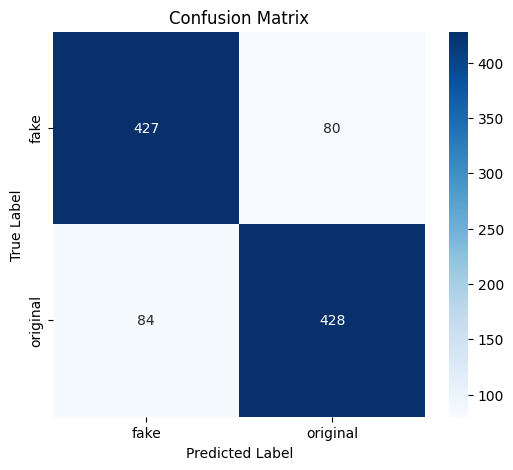

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(test_df['enc_label'], test_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['fake', 'original'], yticklabels=['fake', 'original'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Muril

In [47]:
import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, classification_report

# Model setup
model_name = "google/muril-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model setup
model_name = "google/muril-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model = model.to(device)

# Create a custom dataset class
class ClaimDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

# Tokenize function
def tokenize_data(data):
    return tokenizer(data['cleaned'].tolist(), truncation=True, padding=True, max_length=128)

# Define metrics function
def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

# Custom trainer class
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        outputs = model(**inputs)
        logits = outputs.logits
        labels = inputs["labels"]
        loss = outputs.loss
        predictions = torch.argmax(logits, dim=-1)

        # Calculate training accuracy
        acc = (predictions == labels).float().mean()
        self.log({"train_accuracy": acc.item()})  # Log training accuracy
        return (loss, outputs) if return_outputs else loss
    
    def on_epoch_end(self, args, state, control, **kwargs):
        # Print logs after every epoch
        logs = self.state.log_history
        train_acc = 0
        train_loss = 0
        eval_acc = 0
        eval_loss = 0

        for log in logs:
            if 'train_accuracy' in log:
                train_acc = log['train_accuracy']
            if 'eval_loss' in log:
                eval_loss = log['eval_loss']
            if 'eval_accuracy' in log:
                eval_acc = log['eval_accuracy']
            if 'loss' in log:
                train_loss = log['loss']

        print(f"Epoch {state.epoch}:")
        print(f"  Training Accuracy: {train_acc:.4f}")
        print(f"  Training Loss: {train_loss:.4f}")
        print(f"  Validation Accuracy: {eval_acc:.4f}")
        print(f"  Validation Loss: {eval_loss:.4f}")
        return super().on_epoch_end(args, state, control, **kwargs)

    def save_model(self, output_dir: str, _internal_call: bool = False):
        # Ensure that model weights are contiguous before saving
        model_state_dict = self.model.state_dict()
        for key, tensor in model_state_dict.items():
            if not tensor.is_contiguous():
                model_state_dict[key] = tensor.contiguous()
        # Now save the model as usual
        self.model.save_pretrained(output_dir, state_dict=model_state_dict, _internal_call=_internal_call)

def main():
    # Assuming you have train_df, dev_df, and test_df loaded
    # Tokenize the data
    train_encodings = tokenize_data(train_df)
    dev_encodings = tokenize_data(dev_df)
    test_encodings = tokenize_data(test_df)

    # Prepare labels
    train_labels = torch.tensor(train_df['enc_label'].tolist())
    dev_labels = torch.tensor(dev_df['enc_label'].tolist())

    # Create datasets
    train_dataset = ClaimDataset(train_encodings, train_labels)
    dev_dataset = ClaimDataset(dev_encodings, dev_labels)
    test_dataset = ClaimDataset(test_encodings)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=7,
        weight_decay=0.01,
        save_total_limit=2,
        load_best_model_at_end=True,
        logging_steps=50,
        logging_dir="./logs",
        report_to="tensorboard",
    )

    # Initialize trainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
        compute_metrics=compute_metrics,
    )

    # Train the model
    print("Training the model...")
    trainer.train()

    # Evaluate the model
    print("Evaluating the model...")
    eval_results = trainer.evaluate()
    print(f"Dev Accuracy: {eval_results['eval_accuracy']:.4f}")
    print(f"Dev Loss: {eval_results['eval_loss']:.4f}")

    # Generate predictions on test dataset
    print("Predicting on the test dataset...")
    predictions = trainer.predict(test_dataset)
    predicted_labels = np.argmax(predictions.predictions, axis=1)

    # Calculate accuracy and print classification report
    accuracy = accuracy_score(test_df['enc_label'], predicted_labels)
    report = classification_report(test_df['enc_label'], predicted_labels, digits=4)

    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)

if __name__ == "__main__":
    main()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training the model...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.636100,0.595795,0.741104
2,0.510100,0.485383,0.803681
3,0.384700,0.442133,0.828221
4,0.341200,0.449980,0.829448
5,0.315800,0.503606,0.817178
6,0.252300,0.475006,0.830675
7,0.207600,0.490717,0.833129


Evaluating the model...


Dev Accuracy: 0.8282
Dev Loss: 0.4421
Predicting on the test dataset...
Test Accuracy: 0.8224
Classification Report:
              precision    recall  f1-score   support

           0     0.8559    0.7732    0.8124       507
           1     0.7950    0.8711    0.8313       512

    accuracy                         0.8224      1019
   macro avg     0.8255    0.8221    0.8219      1019
weighted avg     0.8253    0.8224    0.8219      1019



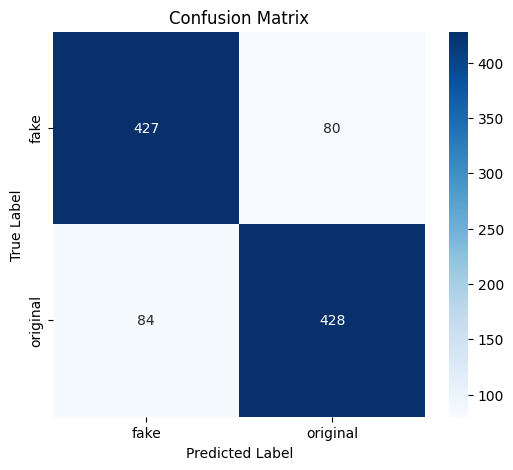

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(test_df['enc_label'], test_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['fake', 'original'], yticklabels=['fake', 'original'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Malayalam Bert

In [50]:
from transformers import logging
logging.set_verbosity_error()

In [51]:
import torch
from sklearn.metrics import accuracy_score, classification_report
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, AutoConfig

# Set random seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Constants
MODEL_NAME = 'l3cube-pune/malayalam-bert'
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Define dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=None, is_labeled=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_labeled = is_labeled

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        if self.is_labeled and self.labels is not None:
            label = self.labels[item]
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask,
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:
            return {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }

# Prepare datasets and dataloaders
train_set = NewsDataset(
    texts=train_df['cleaned'].tolist(),
    labels=train_df['enc_label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    is_labeled=True
)

dev_set = NewsDataset(
    texts=dev_df['cleaned'].tolist(),
    labels=dev_df['enc_label'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    is_labeled=True
)

test_set = NewsDataset(
    texts=test_df['cleaned'].tolist(),
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    is_labeled=False  # test set doesn't have labels
)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
dev_loader = DataLoader(dev_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Define the model
class ClaimClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(ClaimClassifier, self).__init__()
        self.config = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
        self.bert = AutoModel.from_pretrained(model_name, config=self.config)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Use CLS token embedding instead of pooler_output
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.fc(cls_output)



# Initialize model
model = ClaimClassifier(MODEL_NAME, num_labels=2)
model.to(device)

# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# Training and evaluation function
def train_and_evaluate_model():
    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        total_loss = 0
        train_predictions, train_true_labels = [], []
        
        for batch in train_loader:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Store predictions and labels for accuracy calculation
            preds = torch.argmax(outputs, dim=1)
            train_predictions.extend(preds.cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())
        
        # Calculate training accuracy
        train_acc = accuracy_score(train_true_labels, train_predictions)
        train_loss = total_loss / len(train_loader)

        # Evaluation phase
        model.eval()
        dev_predictions, dev_true_labels = [], []
        
        with torch.no_grad():
            for batch in dev_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                # Forward pass
                outputs = model(input_ids, attention_mask)
                preds = torch.argmax(outputs, dim=1)
                
                # Store predictions and labels for accuracy calculation
                dev_predictions.extend(preds.cpu().numpy())
                dev_true_labels.extend(labels.cpu().numpy())
        
        # Calculate development accuracy
        dev_acc = accuracy_score(dev_true_labels, dev_predictions)

        # Print metrics for the epoch
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Dev Accuracy: {dev_acc:.4f}")

# Run training and evaluation
train_and_evaluate_model()

# Predict function for the test set
def predict_test():
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            
            predictions.extend(preds.cpu().numpy())
    
    return predictions

# Generate predictions for the test set
test_predictions = predict_test()

# Evaluation metrics
print(f"Test Accuracy: {accuracy_score(test_df['enc_label'], test_predictions):.4f}")
print("Classification Report:")
print(classification_report(test_df['enc_label'], test_predictions, digits=4))

tokenizer_config.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/951M [00:00<?, ?B/s]

Epoch 1/10, Loss: 0.6409, Train Accuracy: 0.6779, Dev Accuracy: 0.8012
Epoch 2/10, Loss: 0.5337, Train Accuracy: 0.8247, Dev Accuracy: 0.8564
Epoch 3/10, Loss: 0.4752, Train Accuracy: 0.8492, Dev Accuracy: 0.8429
Epoch 4/10, Loss: 0.4114, Train Accuracy: 0.8760, Dev Accuracy: 0.8344
Epoch 5/10, Loss: 0.3458, Train Accuracy: 0.9011, Dev Accuracy: 0.8515
Epoch 6/10, Loss: 0.2896, Train Accuracy: 0.9214, Dev Accuracy: 0.8577
Epoch 7/10, Loss: 0.2264, Train Accuracy: 0.9457, Dev Accuracy: 0.8552
Epoch 8/10, Loss: 0.1915, Train Accuracy: 0.9512, Dev Accuracy: 0.8613
Epoch 9/10, Loss: 0.1544, Train Accuracy: 0.9635, Dev Accuracy: 0.8515
Epoch 10/10, Loss: 0.1319, Train Accuracy: 0.9708, Dev Accuracy: 0.8699
Test Accuracy: 0.8449
Classification Report:
              precision    recall  f1-score   support

           0     0.8993    0.7751    0.8326       507
           1     0.8041    0.9141    0.8556       512

    accuracy                         0.8449      1019
   macro avg     0.8517   

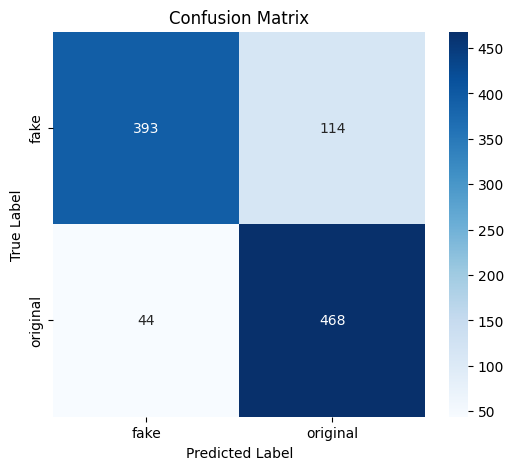

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(test_df['enc_label'], test_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['fake', 'original'], yticklabels=['fake', 'original'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()